In [1]:
%pylab inline
import matplotlib as plt
import numpy as np 

Populating the interactive namespace from numpy and matplotlib


In [12]:
import math 

# --- micrograd ---

class Value: 

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data 
    self.grad = 0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f'Value(data={self.data})'

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out =  Value(self.data + other.data, (self, other), '+') 
    
    def _backward(): 
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other): 
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward(): 
      self.grad  += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out 

  def __pow__(self, other): 
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self, ), f'**{other}')

    def _backward(): 
      self.grad += other * (self.data**(other-1)) * out.grad
    out._backward = _backward

    return out
 
  def __neg__(self): return -1 * self.data                 # -self
  def __sub__(self, other): return self + (-other)         # self - other
  def __radd__(self, other): return self + other           # other + self
  def __rmul__(self, other): return self * other           # other * self
  def __truediv__(self, other): return self.data*other**-1 # self / other
  
  def tanh(self): 
    x = self.data 
    t = (math.exp(2*x) -1) / (math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward(): 
      self.grad += (1-t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self): 
    x = self.data 
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward
    
    return out 

  def log(self):
    x = self.data
    out = Value(math.log(x), (self, ), 'log')

    def _backward():
      self.grad += (1/x) * out.grad
    out._backward =_backward

    return out

  def backward(self):

    visited = set()
    topo = []
    def build_topo(v): 
      if v not in visited: 
        visited.add(v)
        for child in v._prev: 
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0        
    for node in reversed(topo):
      node._backward()

a = Value(2.0,  label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

d = a*b + c; d.label='d'

In [13]:
logits = [Value(2.0), Value(0.3)]

counts = [logit.exp() for logit in logits]
denominator = sum(counts) #Here I am getting the Typeerror
out = [c / denominator for c in counts]


In [15]:

for o in out:
  print(o)



Value(data=0.8455347349164652)
Value(data=0.1544652650835347)


In [2]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

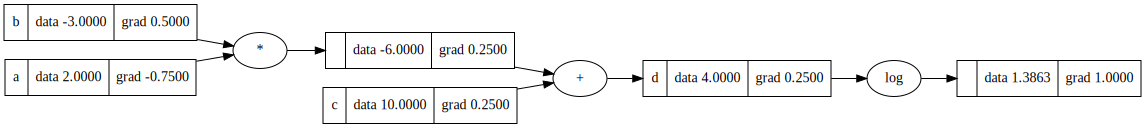

In [29]:
# make sure that graphviz is downloaded on your machine

import os
os.environ["PATH"] += os.pathsep + 'C:\\Users\\bkand\\Downloads\\windows_10_msbuild_Release_graphviz-6.0.2-win32\\Graphviz\\bin' # graphiz exe path

draw_dot(result)

In [42]:
x = Value(2.0, label='x')
y = Value(4.0, label='y')
a = x + y; a.label='a'
b = a * a * a * a; b.label='b'
draw_dot(b)

visited = set()
topo = []
def build_topo(v): 
  if v not in visited: 
    visited.add(v)
    for child in v._prev: 
      build_topo(child)
    topo.append(v)
build_topo(b)

for n in topo: 
  print(n)




(y)
(x)
(a), {(y), (x)}
(), {(a), {(y), (x)}}
(), {(a), {(y), (x)}, (), {(a), {(y), (x)}}}
(b), {(a), {(y), (x)}, (), {(a), {(y), (x)}, (), {(a), {(y), (x)}}}}


In [5]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'


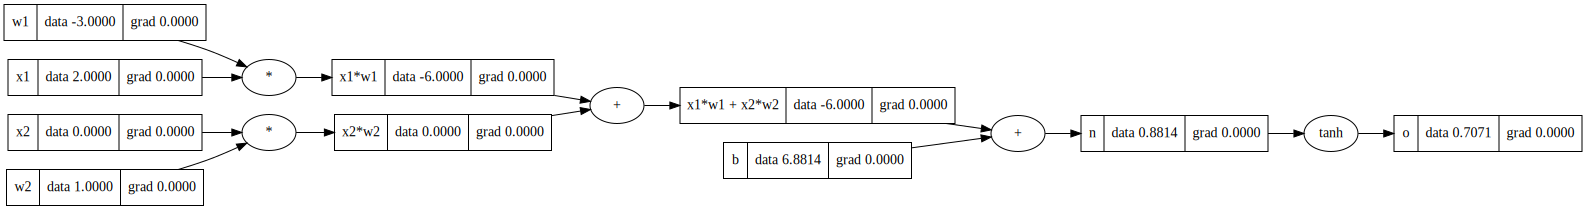

In [6]:
draw_dot(o)

In [7]:
o.grad = 1
o._backward()

In [8]:
# n._backward()
x1w1x2w2._backward()

In [9]:
o.backward()



In [10]:
a = Value(2.0, label='a')
b = Value(4.0, label='b')

a/b

# b.backward()

# draw_dot(b)

Value(data=0.5)

In [11]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ---- 
e = (2 * n).exp()
o = (e - 1) / (e + 1)
# o = n.tanh(); 
# ---- 
o.label = 'o'
o.backward()



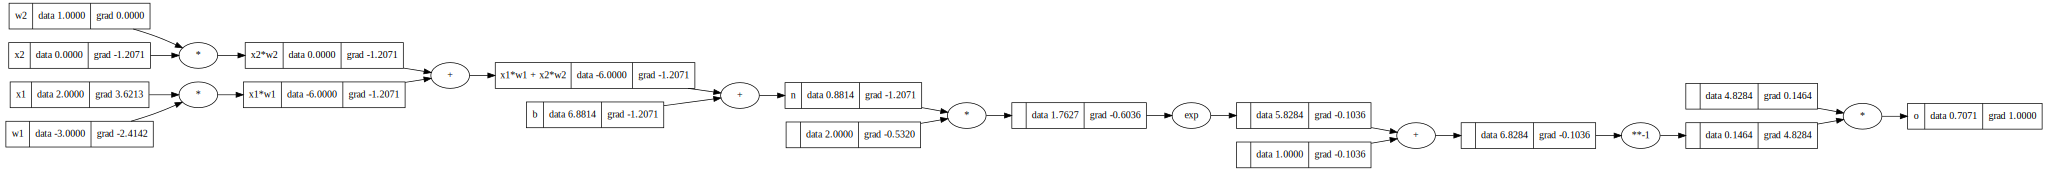

In [12]:
def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)

      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot
draw_dot(o)



In [ ]:
o.grad

In [ ]:

import random 

class Neuron: 
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1, 1))

  def parameters(self): 
    return self.w + [self.b]

  def __call__(self, x):
    # x dot w + b
    act = sum([xi*wi for xi, wi in zip(x, self.w)]) + self.b
    out = act.tanh()
    return out

class Layer: 
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def parameters(self): 
    return [p for n in self.neurons for p in n.parameters()]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

class MLP: 
  def __init__(self, nin, nouts): 
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def parameters(self): 
    return [p for l in self.layers for p in l.parameters()]

  def __call__(self, x): 
    for l in self.layers: 
      x = l(x)
    return x


x = [2.0, 3.0, -1]
# layer = Layer(2, 3)
# layer(x)

mlp = MLP(3, [4, 4, 1])
p = mlp(x)

In [ ]:
# draw_dot(p)

In [ ]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

y_hat = [mlp(x) for x in xs]
y_hat

In [ ]:
y_hat = [mlp(x) for x in xs]
loss = sum([(yi-y_hati)**2 for yi, y_hati in zip(y_hat, ys)])
loss


In [ ]:
for w in mlp.parameters(): 
  w.grad = 0

loss.backward()

for w in mlp.parameters(): 
  w.data += -w.grad * 1e-2

In [ ]:
mlp.layers[0].neurons[0].w[0].grad

In [ ]:
begin_loss = sum([(yi-y_hati)**2 for yi, y_hati in zip(y_hat, ys)])

for i in range(30): 
  y_hat = [mlp(x) for x in xs]

  loss = sum([(yi-y_hati)**2 for yi, y_hati in zip(y_hat, ys)])

  for w in mlp.parameters(): 
    w.grad = 0

  loss.backward()

  for w in mlp.parameters(): 
    w.data += -w.grad * 1e-2

end_loss = sum([(yi-y_hati)**2 for yi, y_hati in zip(y_hat, ys)])

In [ ]:
begin_loss, end_loss

In [ ]:
out = [mlp(x) for x in xs]

In [ ]:
y_hat = [o.data for o in out] 
round_y_hat = [round(y) for y in y_hat] 

mse = sum([(yi-y_hati)**2 for yi, y_hati in zip(y_hat, ys)])
acc = sum([y == ry_hat for y, ry_hat in zip(ys, round_y_hat)])/len(y_hat)
print(f'loss: {mse}, accuracy: {acc}')

